# HookNet

In [1]:
from hooknet.training.trainer import Trainer
from hooknet.model import create_hooknet
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
from matplotlib import pyplot as plt
import gc
from wholeslidedata.samplers.utils import crop_data
from wholeslidedata.visualization.plotting import plot_mask

def plot_inference(patch, ground_truth, prediction):
    colors = ['black', 'red', 'pink', 'purple', 'blue', 'green', 'yellow', 'orange', 'grey']
    fig, axes = plt.subplots(1,3, figsize=(10,10))
    axes[0].imshow(patch)
    plot_mask(ground_truth, axes=axes[1], color_values=colors)
    plot_mask(prediction, axes=axes[2], color_values=colors)
    plt.show()

## Data Loading

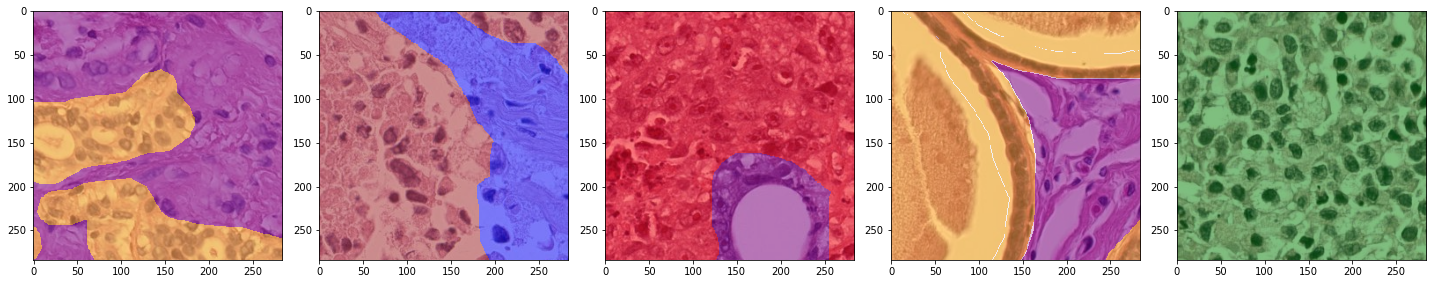

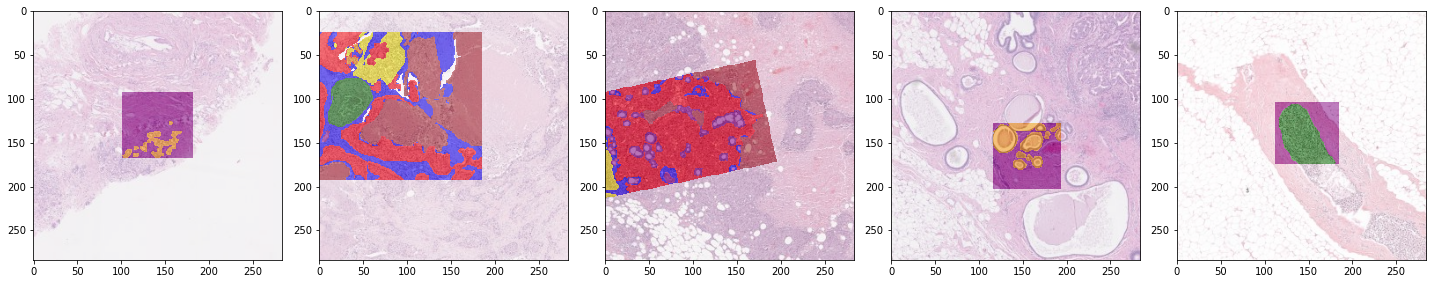

In [2]:
ITERATOR_CONFIG = {
    "wholeslidedata": {
        "default": {
            "seed": 123,
            "yaml_source": "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml",
            "image_backend": 'asap',
            'labels': {
                "roi": 0,
                "invasive tumor": 1,
                "tumor-associated stroma": 2,
                "in-situ tumor": 3 ,
                "healthy glands": 4,
                "necrosis not in-situ": 5,
                "inflamed stroma": 6,
                "rest": 7,
            },
            "annotation_parser": {
                "sample_label_names": ['roi'],
                "sorters": ["${$wholeslidedata.annotation.selector.sort_by_area_with_roi}"],
            },
            "batch_shape": {
                "batch_size": 5,
                "shape": [[284,284,3],[284,284,3]],
                "spacing": [0.5, 8.0],
                "y_shape": [2, 284, 284]
            },
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -(284//2)},
            },

        }
    }
}

mode = 'training'
number_of_batches = 1
cpus=4

with create_batch_iterator(mode=mode, 
                           user_config=ITERATOR_CONFIG, 
                           number_of_batches=number_of_batches, cpus=4) as training_iterator:
    
    for x_batch, y_batch, info in training_iterator:
        plot_batch(x_batch[:,0,...], y_batch[:,0, ...], alpha=0.5)
        plot_batch(x_batch[:,1,...], y_batch[:,1, ...], alpha=0.5)

## Training

In [2]:
ITERATOR_CONFIG = {
    "wholeslidedata": {
        "default": {
            "seed": 123,
            "yaml_source": "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml",
            "image_backend": 'asap',
            "labels": {
                "roi": 0,
                "invasive tumor": 1,
                "tumor-associated stroma": 2,
                "in-situ tumor": 3,
                "healthy glands": 3,
                "necrosis not in-situ": 3,
                "inflamed stroma": 3,
                "rest": 3,
            },
            "annotation_parser": {
                "renamed_labels": {
                    'roi': 0,
                    'invasive tumor': 1,
                    'tumor-associated stroma': 2,
                    'rest': 3, 
                },
                "sample_label_names": ["roi"],
                "sorters": ["${$wholeslidedata.annotation.selector.sort_by_area_with_roi}"],
            },
            "batch_shape": {
                "batch_size": 32,
                "shape": [[284, 284, 3], [284, 284, 3]],
                "spacing": [0.5, 8.0],
                "y_shape": [2, 70, 70, 3],
            },
            "point_sampler_name": "RandomPointSampler",
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -35},
            },
            "sample_callbacks": [
                {
                    "*object": "wholeslidedata.samplers.callbacks.CropSampleCallback",
                    "output_shape": [70, 70],
                },
                {
                    "*object": "wholeslidedata.samplers.callbacks.OneHotEncodingSampleCallback",
                    "labels": "${dataset.labels}",
                },
            ],
        }
    }
}

HOOKNET_CONFIG = {
    'hooknet': {
        'default': {
            'model': {
                'n_classes': 3,
                'n_filters': 64,
                'learning_rate': 0.0001,
            }
        }
    }
}
EPOCHS = 50
STEPS = 100 
CPUS = 4
PROJECT = "HookNet-TIGER" 
LOG_PATH = f"/home/user/{PROJECT}"


In [3]:
trainer = Trainer(iterator_config=ITERATOR_CONFIG, 
                  hooknet_config=HOOKNET_CONFIG, 
                  epochs=EPOCHS, 
                  steps=STEPS, 
                  cpus=CPUS, 
                  project=PROJECT, 
                  log_path=LOG_PATH)

In [ ]:
trainer.train()

wandb: Currently logged in as: mart-vanrijthoven (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


training labels ['tumor-associated stroma', 'rest', 'invasive tumor', 'roi']
validation labels ['tumor-associated stroma', 'rest', 'invasive tumor', 'roi']


/home/user/pathology-whole-slide-data/wholeslidedata/image/wholeslideimage.py:72: UserWarning: spacing 8.0 outside margin (0.3%) for [0.6574764640761666, 1.3149529281523331, 2.6299058563046662, 5.2598117126093324, 10.519623425218665, 21.03924685043733, 42.07849370087466], returning closest spacing: 10.519623425218665
  warnings.warn(


## Patch Inference

In [5]:
ITERATOR_CONFIG = {
    "wholeslidedata": {
        "default": {
            "seed": 123,
            "yaml_source": "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml",
            "image_backend": "asap",
            "labels": {
                "roi": 0,
                "invasive tumor": 1,
                "tumor-associated stroma": 2,
                "in-situ tumor": 3,
                "healthy glands": 3,
                "necrosis not in-situ": 3,
                "inflamed stroma": 3,
                "rest": 3,
            },
            "annotation_parser": {
                "renamed_labels": {
                    'roi': 0,
                    'invasive tumor': 1,
                    'tumor-associated stroma': 2,
                    'rest': 3, 
                },
                "sample_label_names": ["roi"],
                "sorters": ["${$wholeslidedata.annotation.selector.sort_by_area_with_roi}"],
            },
            "batch_shape": {
                "batch_size": 1,
                "shape": [[1244, 1244, 3], [1244, 1244, 3]],
                "spacing": [0.5, 8.0],
                "y_shape": [2, 1244, 1244],
            },
            "point_sampler_name": "RandomPointSampler",
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -515},
            },
        }
    }
}

HOOKNET_CONFIG = {
    'hooknet': {
        'default': {
            'model': {
                'input_shape': [[1244,1244,3], [1244,1244,3]],
                'n_classes': 3,
                'n_filters': 32,
                'model_weights': '/home/user/HookNet-TIGER/hooknet_weights.h5'
            }
        }
    }
}

     

loading weights... /home/user/HookNet-TIGER/hooknet_weights.h5


/home/user/pathology-whole-slide-data/wholeslidedata/image/wholeslideimage.py:72: UserWarning: spacing 0.5 outside margin (0.3%) for [0.6574764640761666, 1.3149529281523331, 2.6299058563046662, 5.2598117126093324, 10.519623425218665, 21.03924685043733, 42.07849370087466], returning closest spacing: 0.6574764640761666
  warnings.warn(
/home/user/pathology-whole-slide-data/wholeslidedata/image/wholeslideimage.py:72: UserWarning: spacing 8.0 outside margin (0.3%) for [0.6574764640761666, 1.3149529281523331, 2.6299058563046662, 5.2598117126093324, 10.519623425218665, 21.03924685043733, 42.07849370087466], returning closest spacing: 10.519623425218665
  warnings.warn(


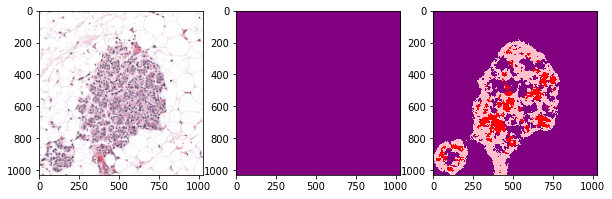

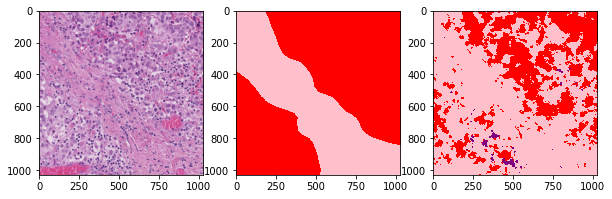

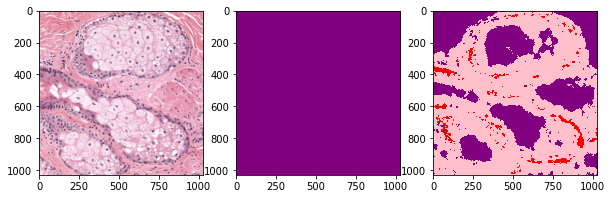

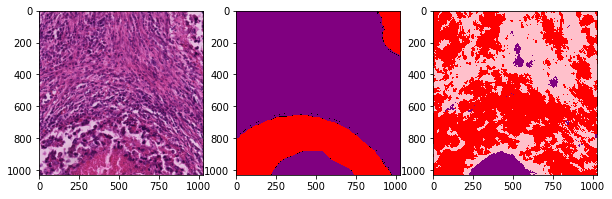

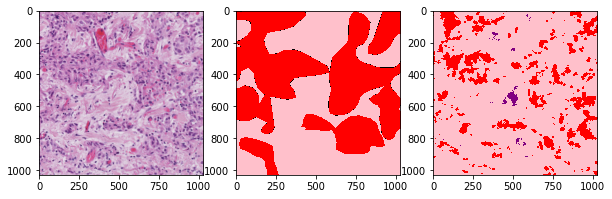

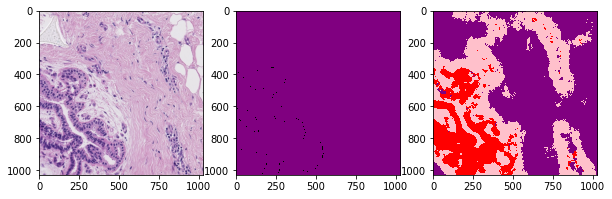

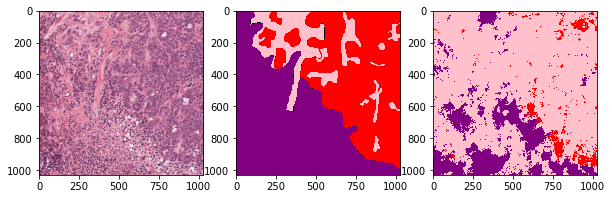

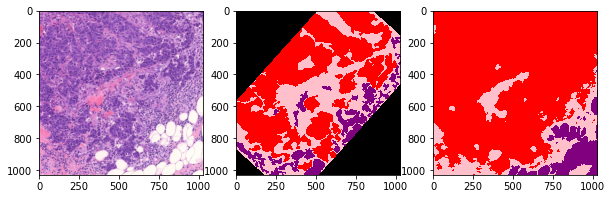

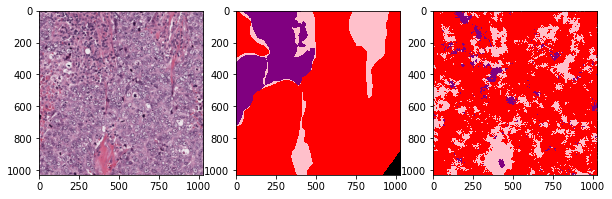

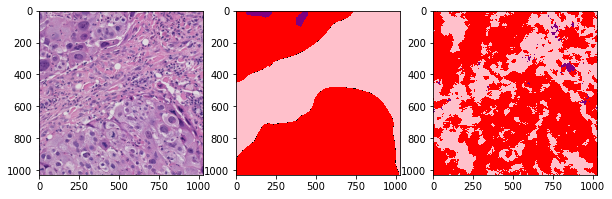

In [6]:
hooknet = create_hooknet(config=HOOKNET_CONFIG)


with create_batch_iterator(
    user_config=ITERATOR_CONFIG,
    mode='validation',
    cpus=4,
) as validation_batch_generator:
    for _ in range(10):
        x_batch, y_batch, info = next(validation_batch_generator)
        x_batch = list(x_batch.transpose(1, 0, 2, 3, 4))
        predictions = hooknet.predict_on_batch(x_batch)
        x_patch = crop_data(x_batch[0][0], hooknet._out_shape[:2])
        y_patch = crop_data(y_batch[0][0], hooknet._out_shape[:2])
        plot_inference(x_patch, y_patch, predictions[0])